In [ ]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from sklearn.linear_model import LinearRegression
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Функция для расчета WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [3]:
df = pd.read_csv('для регрессии.csv', parse_dates=['report_date'])

In [5]:
cat = df.copy()
cat.shape
cat=cat[(cat['target_area'].notnull()) & (cat['target_cost'].notnull())].reset_index(drop=True)
cat.shape[0]

7065

In [7]:
def split_train_oot(data):
    # Находим самую позднюю дату в данных
    latest_date = data['report_date'].max()

    # Вычисляем дату, которая была три месяца назад от самой поздней даты
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # Отбираем строки, где report_date попадает в последние три месяца
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # Теперь заполним NaN значения в столбце 'split_type' значением 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [8]:
# Функция для расчета всех метрик
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [9]:
def shap_gr(name_model, values):# Инициализация SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # Создаем фигуру с регулируемым местом для шкалы
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # Настройки графика
    ax1.set_title("Важность признаков по SHAP значениям", fontsize=14, pad=20)
    ax1.set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
    ax1.set_ylabel("Признаки", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [10]:
cat = split_train_oot(cat)

# Модель

# Тест 1

In [11]:
drop_cols_pickle = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_cost',
    'target_area'
]

In [12]:
data_for_pickle = cat.drop(columns=drop_cols_pickle)
# Загружаем модель area
with open('model_area.pkl', 'rb') as f:
    model_area = pickle.load(f)

# Загружаем модель cost
with open('model_cost.pkl', 'rb') as f:
    model_cost = pickle.load(f)

In [13]:
model_area_predict = model_area.predict(data_for_pickle)
model_cost_predict = model_cost.predict(data_for_pickle)

In [14]:
cat['target_area_diff'] = cat['target_area'] - model_area_predict
cat['target_cost_diff'] = cat['target_cost'] - model_area_predict

In [15]:
cat['weight'] = cat['target_cost_diff']**2

In [16]:
cat['target_elasticity'] = cat['target_area_diff'] / cat['target_cost_diff']

In [17]:
target_ = 'target_elasticity'

In [ ]:
cat = cat[cat['target_elasticity']<0]

In [20]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_cost',
    'target_area',
    'target_area_diff',
    'target_cost_diff',
    'weight',
    target_
]

In [ ]:

# Разделяем данные
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]


# Инициализация и обучение линейной регрессии с весами
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=train_data['weight'])

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)



# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test') 
])

# Сохраняем результаты
metrics_df_base = metrics_df

In [22]:
metrics_df_base

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,0.000313,2.250734e-07,0.000474,16.090166,0.568682,0.332508,-0.000551,-0.000546,3617
1,test,0.001282,2.725122e-06,0.001651,2.142954,0.994518,-0.858149,-0.001289,-0.000032,926


# Отбор фич

In [23]:
# Подготовка данных
cat['report_date'] = pd.to_datetime(cat['report_date'])

# Уникальные значения по времени в тренировочной выборке
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# Список для сбора выбранных фич и метрик
features_across_splits = []
metrics_across_splits = []

# Инициализация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Сортируем данные по дате для корректного разбиения
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_weights = train_df['weight'].iloc[train_index]
    val_weights = train_df['weight'].iloc[val_index]

    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\n🔹 Сплит {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # Инициализация и обучение линейной регрессии
    model = LinearRegression()
    model.fit(
        train_split[feature_columns], 
        train_split[target_],
        sample_weight=train_weights
    )
    
    # Предсказания
    y_train_pred = model.predict(train_split[feature_columns])
    y_val_pred = model.predict(val_split[feature_columns])
    
    # Расчет метрик для train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred, sample_weight=train_weights),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred, sample_weight=train_weights)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred, sample_weight=train_weights)
    }
    
    # Расчет метрик для validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred, sample_weight=val_weights),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred, sample_weight=val_weights)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred, sample_weight=val_weights)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # Отбор фичей через анализ коэффициентов (упрощенный вариант)
    coef_df = pd.DataFrame({
        'feature': feature_columns,
        'coef': model.coef_,
        'abs_coef': np.abs(model.coef_)
    })
    selected_features_names = coef_df.nlargest(100, 'abs_coef')['feature'].tolist()
    print(f" Отобрано фичей: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame(metrics_across_splits)

# Форматируем даты 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# Переупорядочиваем столбцы
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# Анализ фичей
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n Итоговые устойчивые фичи (встречались >= 2 раз):")
print("Количество:", len(final_features))


🔹 Сплит 1: train = 2022-03-01 00:00:00 - 2022-10-01 00:00:00, val = 2022-10-01 00:00:00 - 2023-03-01 00:00:00
 Отобрано фичей: 100

🔹 Сплит 2: train = 2022-03-01 00:00:00 - 2023-03-01 00:00:00, val = 2023-03-01 00:00:00 - 2023-07-01 00:00:00
 Отобрано фичей: 100

🔹 Сплит 3: train = 2022-03-01 00:00:00 - 2023-07-01 00:00:00, val = 2023-07-01 00:00:00 - 2023-12-01 00:00:00
 Отобрано фичей: 100

🔹 Сплит 4: train = 2022-03-01 00:00:00 - 2023-12-01 00:00:00, val = 2023-12-01 00:00:00 - 2024-03-01 00:00:00
 Отобрано фичей: 100

🔹 Сплит 5: train = 2022-03-01 00:00:00 - 2024-03-01 00:00:00, val = 2024-03-01 00:00:00 - 2024-06-01 00:00:00
 Отобрано фичей: 100

 Итоговые устойчивые фичи (встречались >= 2 раз):
Количество: 121


In [24]:
metrics_df_select_features

,split,start_date,end_date,n_samples,mean_target,mean_pred,mae,rmse,mape,wape,r2
0,fold_1_train,2022-03-01,2022-10-01,607,-0.000484,-0.000484,2.355214e-10,3.180966e-10,0.000009,4.545328e-07,1.000000
1,fold_1_val,2022-10-01,2023-03-01,602,-0.000573,-0.002060,1.886505e-02,7.285672e-02,2769.492803,2.776128e+01,-21311.842712
2,fold_2_train,2022-03-01,2023-03-01,1209,-0.000528,-0.000523,1.532634e-04,2.402653e-04,10.798857,3.917817e-01,0.729606
3,fold_2_val,2023-03-01,2023-07-01,602,-0.000653,0.001647,2.621140e-03,3.173529e-03,37.290229,3.978244e+00,-30.230989
4,fold_3_train,2022-03-01,2023-07-01,1811,-0.000569,-0.000566,2.237861e-04,3.314917e-04,12.288180,5.064074e-01,0.566351
5,fold_3_val,2023-07-01,2023-12-01,602,-0.000566,0.001983,2.694770e-03,3.077150e-03,26.167783,4.660095e+00,-38.139699
6,fold_4_train,2022-03-01,2023-12-01,2413,-0.000569,-0.000565,2.424555e-04,3.625575e-04,11.671838,5.397254e-01,0.475182
7,fold_4_val,2023-12-01,2024-03-01,602,-0.000515,-0.001240,1.045828e-03,1.357066e-03,31.758622,1.949715e+00,-8.490842
8,fold_5_train,2022-03-01,2024-03-01,3015,-0.000558,-0.000554,2.439987e-04,3.703145e-04,10.656092,5.614560e-01,0.422347
9,fold_5_val,2024-03-01,2024-06-01,602,-0.000516,-0.000537,3.741459e-04,5.543204e-04,11.701871,7.754518e-01,-0.414515


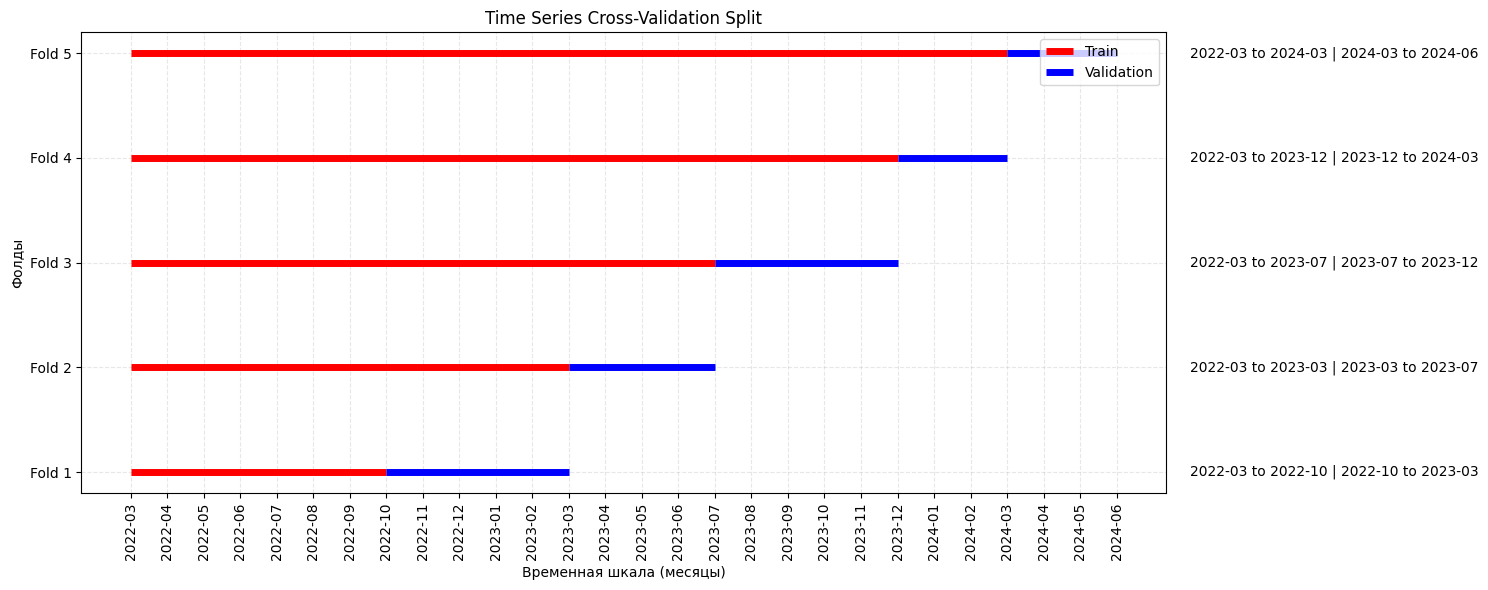

In [25]:
plt.figure(figsize=(15, 6))

# Получаем все уникальные даты
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # Формат YYYY-MM

# Цвета для train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # Находим индексы дат
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # Рисуем линии
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# Настройка графика
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('Временная шкала (месяцы)')
plt.ylabel('Фолды')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# Добавим подписи дат для каждого фолда
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [26]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__3M,expon_cost__g_building__pc_cost_diff_rel__min__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__1_4M,balance__g_building__rooms_1__structure,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__max__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__avg__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__6M,expon_cost__g_building__pc_cost_diff_rel__min__1_4M,area__g_building__smt_projected_total_area__fintech_reservation__count,...,expon_cost__g_building__pc_cost_diff_rel__min__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__min__1_13M,expon_cost__g_building__pc_cost_diff_rel__avg__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__max__12M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1M
3,0.030000,-0.003587,-0.050003,-0.049398,0.078139,-0.049997,-0.019353,-0.050003,-0.050003,0.0,...,-0.050003,-0.050002,-0.009326,-0.050003,-0.013696,-0.049997,-0.048962,-0.049655,0.027715,0.003000
4,0.030006,-0.002099,-0.050003,-0.013544,0.076088,0.005007,-0.018344,-0.050003,-0.050003,0.0,...,-0.050003,-0.050002,-0.007924,-0.050003,-0.012567,0.030000,-0.013484,0.009547,0.030005,0.030000
5,0.030006,0.010260,-0.050003,-0.011838,0.070994,0.030003,0.000022,-0.050003,-0.050003,0.0,...,-0.050003,-0.050002,-0.007118,-0.050003,0.002788,0.030005,-0.011715,0.022762,0.030005,0.007998


In [27]:
# Разделение столбцов
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые столбцы:", numeric_cols)
print("Категориальные столбцы:", categorical_cols)

Числовые столбцы: ['expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__1_4M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__3M', 'expon_cost__g_building__pc_cost_diff_rel__min__1_7M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__1_4M', 'balance__g_building__rooms_1__structure', 'expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__max__1_2M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__avg__3M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__6M', 'expon_cost__g_building__pc_cost_diff_rel__min__1_4M', 'area__g_building__smt_projected_total_area__fintech_reservation__count', 'expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__12M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_1__avg__1_2M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__6M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__6M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_2__min__3M', 'expon_cost__g_building__pc_cost_diff_rel__rooms_3plus_

In [28]:
# Создаем словарь для YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'weight': ['weight'],
    'target' : [target_]
}

# Записываем в YAML-файл
with open('features_model_elasticity_linear_zero.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [29]:
# загрузим фичи
with open('features_model_elasticity_linear_zero.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
weight_col = config.get('weight', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols+weight_col

In [30]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,expon_cost__g_building__pc_cost_diff_rel__rooms_2__max__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__3M,expon_cost__g_building__pc_cost_diff_rel__min__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__1_4M,balance__g_building__rooms_1__structure,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__max__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__avg__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__6M,weight,expon_cost__g_building__pc_cost_diff_rel__min__1_4M,...,expon_cost__g_building__pc_cost_diff_rel__min__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__min__1_13M,expon_cost__g_building__pc_cost_diff_rel__avg__6M,expon_cost__g_building__pc_cost_diff_rel__rooms_3plus__min__1_4M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__3M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__max__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__avg__1_7M,expon_cost__g_building__pc_cost_diff_rel__rooms_2__avg__1_2M,expon_cost__g_building__pc_cost_diff_rel__rooms_0__max__12M,expon_cost__g_building__pc_cost_diff_rel__rooms_1__min__1M
0,0.030000,-0.003587,-0.050003,-0.049398,0.078139,-0.049997,-0.019353,-0.050003,2.139383e+10,-0.050003,...,-0.050003,-0.050002,-0.009326,-0.050003,-0.013696,-0.049997,-0.048962,-0.049655,0.027715,0.003000
1,0.030006,-0.002099,-0.050003,-0.013544,0.076088,0.005007,-0.018344,-0.050003,2.222083e+10,-0.050003,...,-0.050003,-0.050002,-0.007924,-0.050003,-0.012567,0.030000,-0.013484,0.009547,0.030005,0.030000
2,0.030006,0.010260,-0.050003,-0.011838,0.070994,0.030003,0.000022,-0.050003,2.225148e+10,-0.050003,...,-0.050003,-0.050002,-0.007118,-0.050003,0.002788,0.030005,-0.011715,0.022762,0.030005,0.007998
3,0.016005,0.003194,-0.050003,0.002349,0.065438,0.012006,0.000111,-0.029344,2.452901e+10,-0.018000,...,-0.029344,-0.050002,0.003237,-0.018000,0.002797,0.030005,-0.002694,0.005824,0.030005,-0.029344
4,0.062611,0.005281,-0.153637,0.005938,0.071479,0.103249,0.008194,-0.011864,3.328954e+10,-0.153637,...,-0.153637,-0.153637,0.006716,-0.073544,0.006892,0.034270,0.005464,0.005743,0.205265,0.000004


In [31]:
filtered_df = split_train_oot(filtered_df)

# Модель 2 на выбранных фичах

In [33]:
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date','weight',
                     target_])
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type','smt_building_addressid', 'report_date','weight',
                     target_])
y_test = test_data[target_]


# Инициализация и обучение линейной регрессии с весами
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=train_data['weight'])

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)



# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test') 
])

# Сохраняем результаты
metrics_df_with_select_features = metrics_df

In [35]:
metrics_df_with_select_features

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,0.000371,3.280807e-07,0.000573,17.736064,0.673143,0.027024,-0.000551,-0.000479,3617
1,test,0.000908,2.024214e-06,0.001423,1.593352,0.704381,-0.380228,-0.001289,-0.000504,926


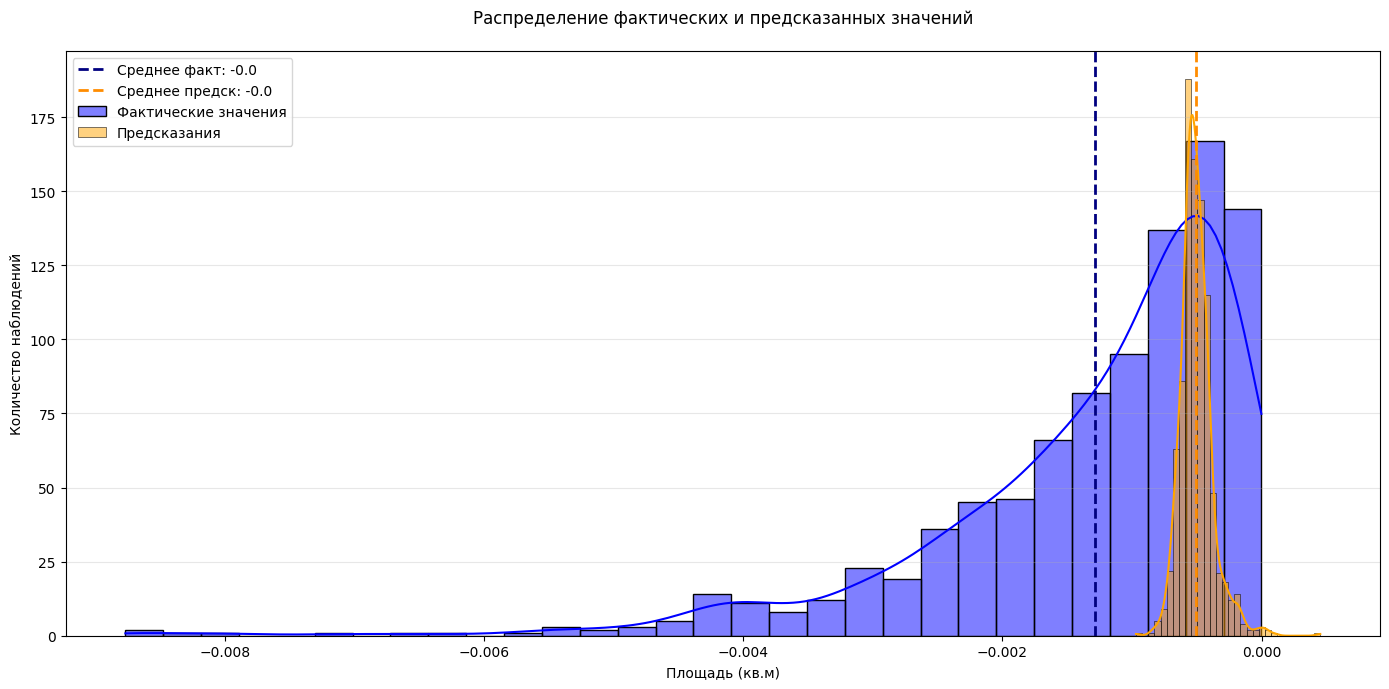

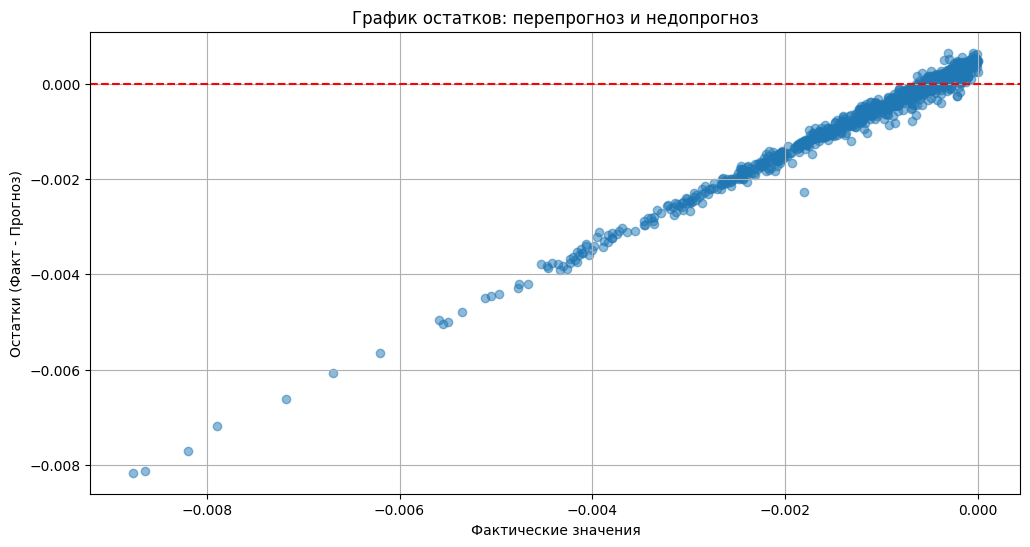

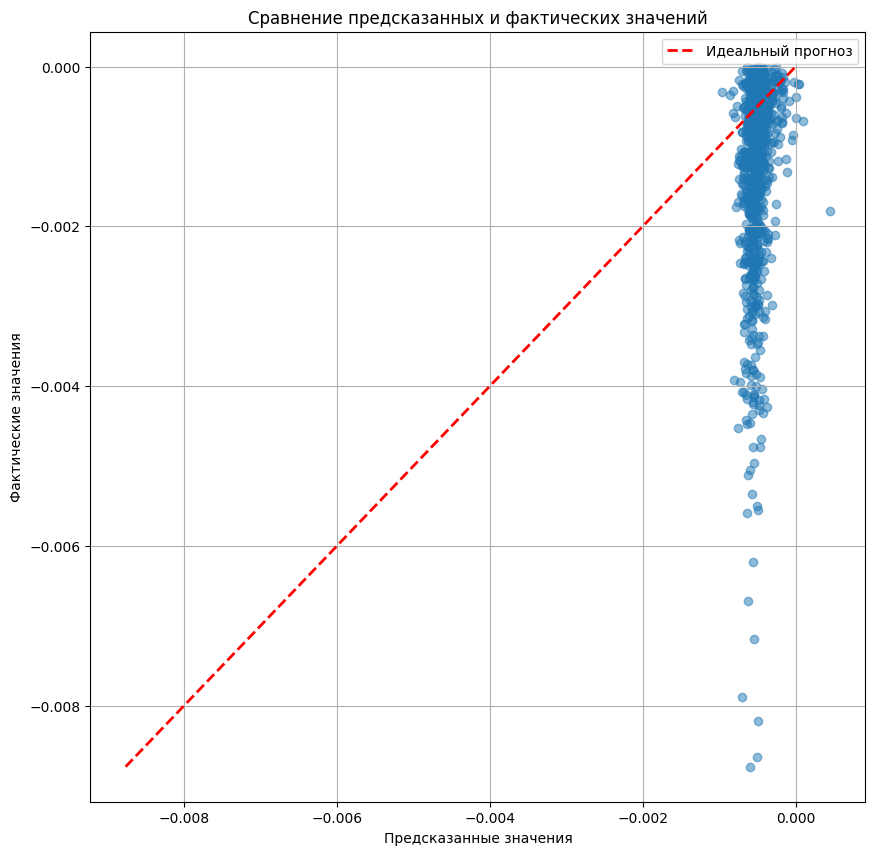

In [36]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()

# OPTUNA

In [37]:
# Разделяем данные
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date','weight',target_])
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', 'weight',target_])
y_test = test_data[target_]

# 3. Модифицированная функция objective для линейной модели
def objective(trial):
    params = {
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False]),
        "n_jobs": -1
    }
    
    model = LinearRegression(**params)
    
    # Для линейной модели sample_weight передается в fit
    model.fit(
        X_train, 
        y_train,
        sample_weight=train_data['weight']
    )
    
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds) 

# 4. Запуск Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10)  # Уменьшил количество trials, так как линейная модель проще

# 5. Финальное обучение
best_params = study.best_params.copy()

final_model = LinearRegression(**best_params)
final_model.fit(
    X_train,
    y_train,
    sample_weight=train_data['weight']
)

# Предсказания и метрики
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

[I 2025-05-20 22:18:16,988] A new study created in memory with name: no-name-17fe2a39-16e2-4fc7-934f-3abd4cf9b405
[I 2025-05-20 22:18:17,035] Trial 0 finished with value: 0.0010527816193659826 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 0.0010527816193659826.
[I 2025-05-20 22:18:17,045] Trial 1 finished with value: 0.0009078742706490165 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 0.0009078742706490165.
[I 2025-05-20 22:18:17,056] Trial 2 finished with value: 0.0009146702045894795 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 1 with value: 0.0009078742706490165.
[I 2025-05-20 22:18:17,067] Trial 3 finished with value: 0.0009078742706490165 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 1 with value: 0.0009078742706490165.
[I 2025-05-20 22:18:17,101] Trial 4 finished with value: 0.0010527816193659826 and parameters: {'fit_intercept': False, 'posi

In [38]:
metrics_df

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,0.000371,3.280807e-07,0.000573,17.736064,0.673143,0.027024,-0.000551,-0.000479,3617
1,test,0.000908,2.024214e-06,0.001423,1.593352,0.704381,-0.380228,-0.001289,-0.000504,926


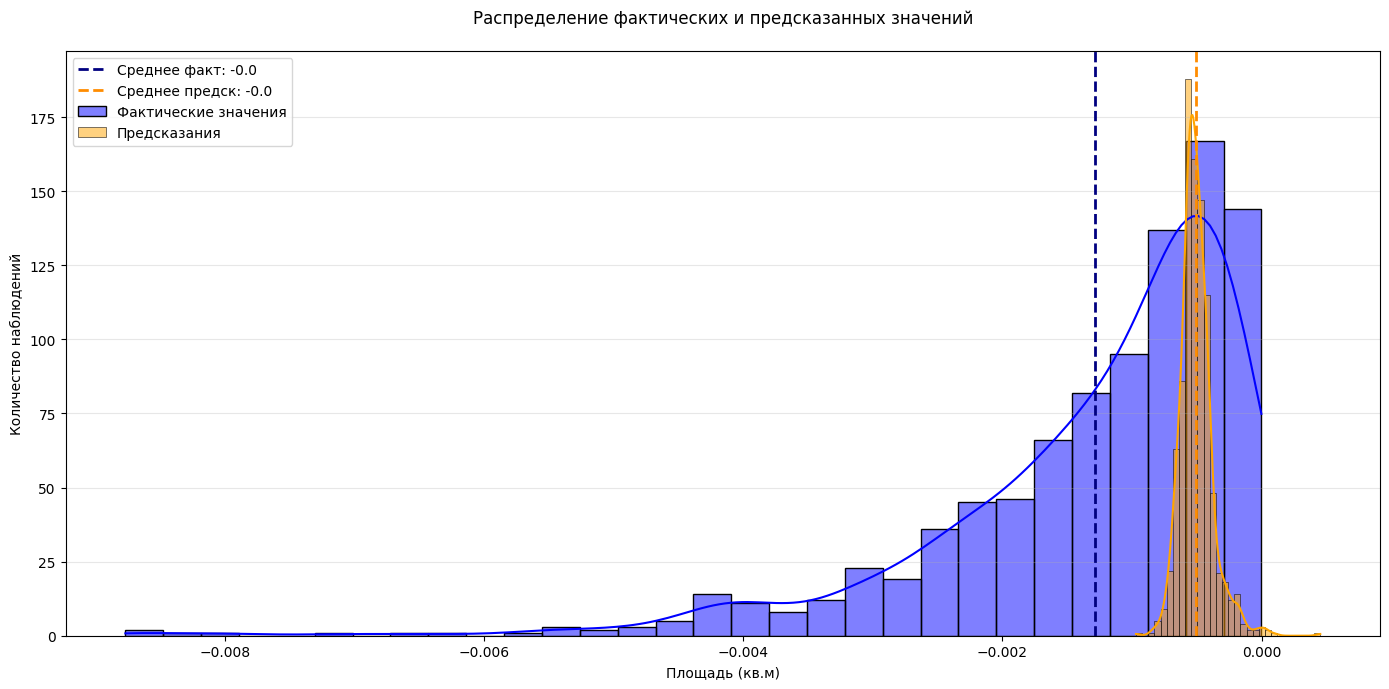

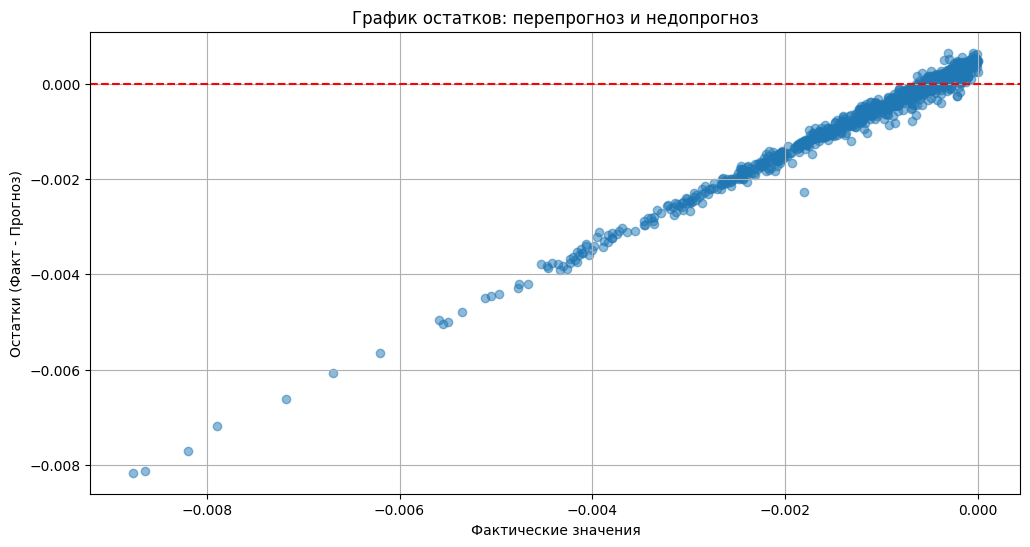

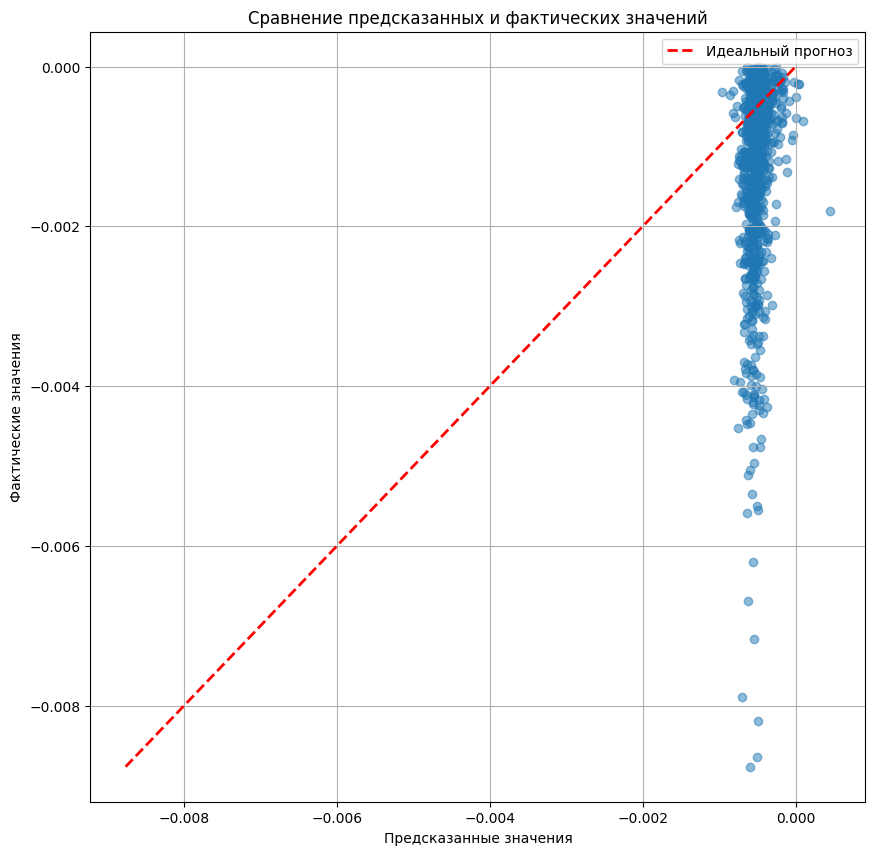

In [39]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()


In [40]:
metrics_df_base.insert(0, 'stage', 'Базовая модель')
metrics_df_with_select_features.insert(0, 'stage', 'Модель с отбором признаков')
metrics_df.insert(0, 'stage', 'Оптимизированная модель (Optuna)')

In [41]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df], ignore_index=True)
result

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,Базовая модель,train,0.000313,2.250734e-07,0.000474,16.090166,0.568682,0.332508,-0.000551,-0.000546,3617
1,Базовая модель,test,0.001282,2.725122e-06,0.001651,2.142954,0.994518,-0.858149,-0.001289,-0.000032,926
2,Модель с отбором признаков,train,0.000371,3.280807e-07,0.000573,17.736064,0.673143,0.027024,-0.000551,-0.000479,3617
3,Модель с отбором признаков,test,0.000908,2.024214e-06,0.001423,1.593352,0.704381,-0.380228,-0.001289,-0.000504,926
4,Оптимизированная модель (Optuna),train,0.000371,3.280807e-07,0.000573,17.736064,0.673143,0.027024,-0.000551,-0.000479,3617
5,Оптимизированная модель (Optuna),test,0.000908,2.024214e-06,0.001423,1.593352,0.704381,-0.380228,-0.001289,-0.000504,926


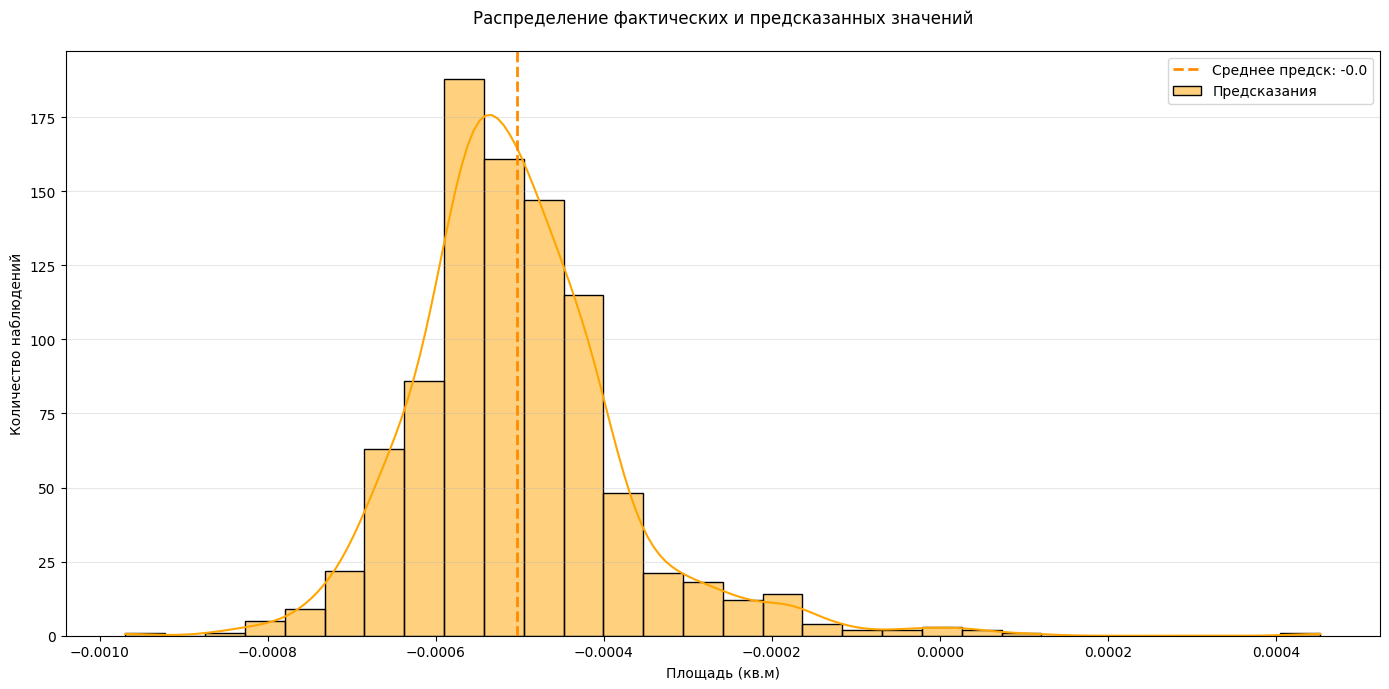

In [42]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))
# Гистограмма с наложением KDE
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True)

# Добавляем линии средних
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Сохраняем модель
with open('model_elasticity_linear_zero.pkl', 'wb') as f:
    pickle.dump(final_model, f)